Project: Kanye in Space

Description: ray tracing various album covers against a space background with a stationary point of view

Notes:

Each album cover object has
* orthonormal basis in R3 whose columns are:
    * column 1: vector orthogonal to plane
    * column 2: vector pointing to top of album cover
    * column 3: vector pointing to left of album cover
* point in space corresponding to the center of the orthonormal basis
* pixelmap of the actual albumcover

You can manipulate the album cover in space by:
* moving it in the three dimensions
* rotating along any of the three axes 

To accomplish this, I need:
* to move an album cover object in space by changing it's position vector
* to rotate an album cover object by changing it's orthonormal basis
    * For this I need to be able to construct a rotation matrix, and mutilply matrices
* to see where a ray of light would intersect the plane formed by the album  cover
* to project that intersetcion point onto the xy-plane and see where it would be on the pixelmap
    * for this I need to be able to do matrix inverse and matrix multiply

After every single change to the position/direction of the album cover I need to:
* project a "ray" of light from my observation point, through every pixel on my "viewfinder" (i.e. the screen)
* calculate the intersection point of the "ray" onto the plane of the album cover
* find out if the intersection point is within the bounds of the album cover
* if it is, paint the pixel that the ray went through accordingly

Eventually, I want to add support for multiple album covers

Update, 4/27

multi-sampling anti-aliasing is implemented

next up is shadows? fixed light source? multiple albums? 

to implement any of these, I need to be able to reflect off of a surface (for mirror surface), and to be able to change the angle of reflection slightly (for glossy surfaces) and a lot (for matte surfaces). 

In [1]:
from PIL import Image
from IPython.display import display
import numpy as np
from math import sin, cos


In [2]:
im = Image.open("kanye_1.jpg")
im_arr = np.asarray(im)
im_arr.shape
# display(im)

(680, 680, 3)

In [3]:
#get a plane/line intersect
def pli(r0, point, normal, vector):
    #l is initial point for line
    #p is initial point for plane
    #n is normal vector to plane
    #v is direction vector of line
    
    lx,ly,lz = r0
    px,py,pz = point
    nx,ny,nz = normal
    vx,vy,vz = vector
    
    dx = px-lx
    dy = py-ly
    dz = pz-lz
    
#     num = nx*(px-lx) + ny*(py-ly) + nz*(pz-lz)
#     den = nx*vx + ny*vy + nz*dz

    num = np.dot(normal, (point -r0))
    den = np.dot(normal,vector)
    
    if den != 0:
        t = num/den
        xi = lx + t*vx
        yi = ly + t*vy
        zi = lz + t*vz
        return (xi,yi,zi)
    return None

def rotate(U, axis, rad):
    #axis = 0,1,2 = x,y,z
    #rad is radians
    c = cos(rad)
    s = sin(rad)
    R = np.asarray([[1,0,0],[0,1,0],[0,0,1]])
    if axis == 0:
        R = np.asarray([[1,0,0],
                        [0,c,-s],
                        [0,s,c]])
    elif axis == 1:
        R = np.asarray([[c,0,-s],
                        [0,1,0],
                        [s,0,c]])
    elif axis == 2:
        R = np.asarray([[c,-s,0],
                        [s,c,0],
                        [0,0,1]])
    return np.matmul(R,U)

def move(P, axis, dv):
    R = np.asarray([P[0], P[1], P[2]])
    R[axis] += dv
    return R

def proj(U, intersect):
    Uinv = np.linalg.inv(U)
    proj = np.matmul(Uinv, intersect)
    return tuple(proj)

def clamp(x): 
    return max(0, min(x, 255))

def rgbtohex(rgb):
    r,g,b = rgb
    return int("{0:02x}{1:02x}{2:02x}".format(clamp(r), clamp(g), clamp(b)), base=16)/16777215
    

In [45]:
#gets inverse of 3x3 matrix:

camera = np.asarray([0,0,1000])
# vf_size = im_arr.shape[0]
vdim = 1000
vf_shp = (vdim,vdim) #needs to be even
# viewfinder = np.
U = np.asarray([[1,0,0],[0,1,0],[0,0,1]]) #U[2] is normal to the plane
P = np.asarray([0,0,0])

P = np.asarray([0,0,-250])
U = rotate(U, 0, 0.3)
U = rotate(U, 1, 3.14159)
U = rotate(U, 2, 1)

In [46]:
def project_ray(x,y):
    z = 0
    scr_pos = np.asarray([x,y,z])
    av = scr_pos - camera
    V = av/(np.linalg.norm(av))
    intersect = pli(camera, P, U[2], V)
    ix,iy,iz = proj(U, intersect)
    if(ix < 0 or ix >= im_arr.shape[0] or iy < 0 or iy >= im_arr.shape[1]):
        return np.asarray([0,0,0])
    else:
        return im.getpixel((iy,ix))

In [55]:
def find_pixel(i,j):
    tol = 0.0001
    #i,j pixel located at i - (vf_shp[0]//2) + 0.5
    N = 2
    l = np.ndarray((N*N,3))
    for ii in range(0,N):
        for jj in range(0,N):
            dx = ii/N + (0.5/N)
            dy = jj/N + (0.5/N)
            input_x = i - (vf_shp[0]//2) + dx
            input_y = j - (vf_shp[1]//2) + dy
#             print(input_x, ", ", input_y)
            order = ii*N + jj
            l[order] = project_ray(input_x,input_y)
#     print(l)
    return np.average(l, axis=0)
    

In [56]:
def get_image():
    shp = vf_shp + (3,)
    a = np.zeros(shp, dtype="uint8")

    for i in range(vf_shp[0]):
        print(i, end="\r")
        for j in range(vf_shp[1]):
            a[i,j] = find_pixel(i,j)
    #         a[i,j] = im.getpixel((i,j))
        #rgbtohex(im.getpixel((i,j)))

    ret = Image.fromarray(a)
    return ret

In [57]:
kis = get_image()
kis.save("kis.jpg", "JPEG")

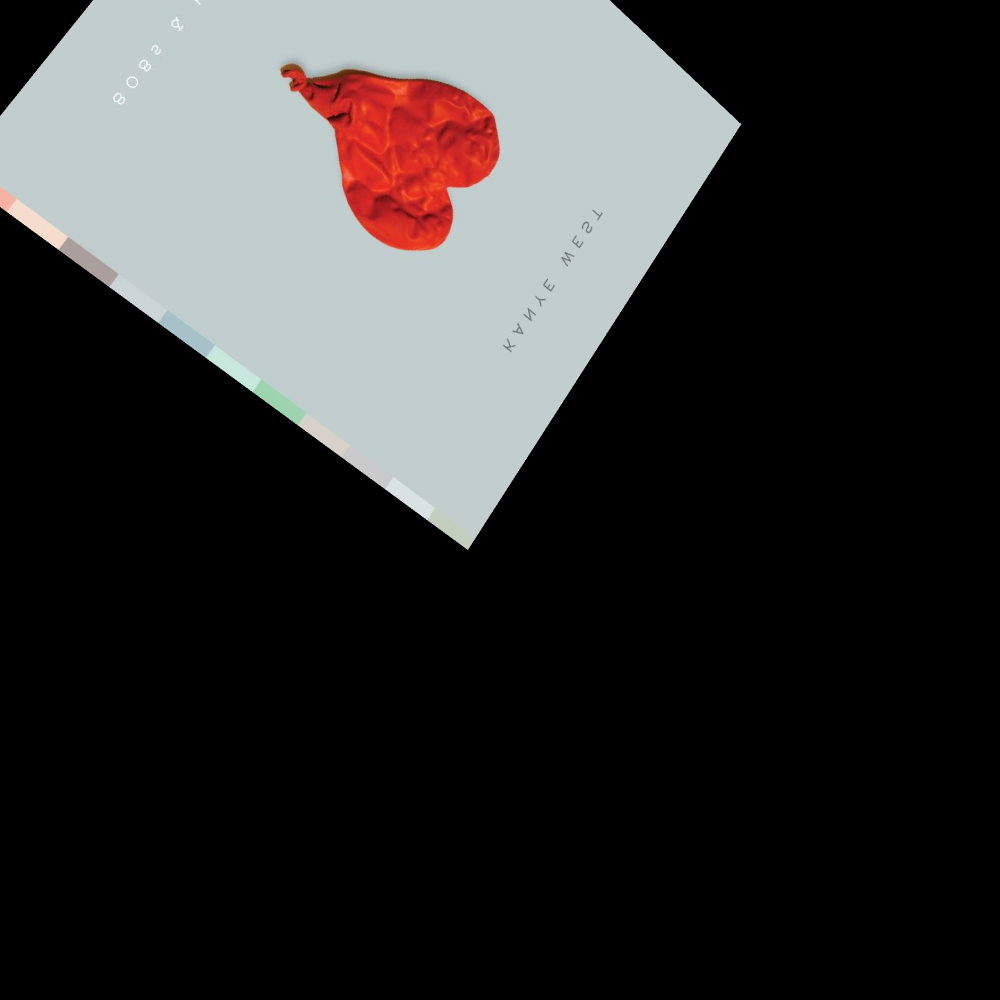

In [58]:
display(kis)